<a href="https://colab.research.google.com/github/xx529/NLP/blob/main/TouTiao_text/BaseLine_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
1. 根据句子内容做分类任务
2. baseline 采用 tfidf 模型

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import jieba
from collections import defaultdict

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploring

In [126]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks Project/NLP/TouTiao_text/train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53360 entries, 0 to 53359
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          53360 non-null  int64 
 1   label       53360 non-null  int64 
 2   label_desc  53360 non-null  object
 3   sentence    53360 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.6+ MB


In [127]:
df_train.head()

,id,label,label_desc,sentence
0,0,108,news_edu,上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，大家怎么看待这种事？
1,1,104,news_finance,商赢环球股份有限公司关于延期回复上海证券交易所对公司2017年年度报告的事后审核问询函的公告
2,2,106,news_house,通过中介公司买了二手房，首付都付了，现在卖家不想卖了。怎么处理？
3,3,112,news_travel,2018年去俄罗斯看世界杯得花多少钱？
4,4,109,news_tech,剃须刀的个性革新，雷明登天猫定制版新品首发


In [128]:
df_train['label'].value_counts() / len(df_train) * 100

109    11.160045
104     9.745127
102     9.325337
113     9.091079
107     7.717391
101     7.648051
103     7.479385
110     6.806597
108     6.441154
116     6.353073
112     6.311844
115     5.408546
106     3.948651
100     2.082084
114     0.481634
Name: label, dtype: float64

In [129]:
df_train['sentence_cut'] = df_train['sentence'].apply(jieba.lcut)
df_train['sentence_cut']

0        [上课时, 学生, 手机, 响个, 不停, ，, 老师, 一怒之下, 把, 手机, 摔, 了...
1        [商赢, 环球, 股份, 有限公司, 关于, 延期, 回复, 上海证券交易所, 对, 公司,...
2        [通过, 中介, 公司, 买, 了, 二手房, ，, 首付, 都, 付, 了, ，, 现在,...
3                  [2018, 年, 去, 俄罗斯, 看, 世界杯, 得花, 多少, 钱, ？]
4              [剃须刀, 的, 个性, 革新, ，, 雷明登, 天猫, 定制, 版, 新品, 首发]
                               ...                        
53355    [5, 月, 11, 日中超, 北京国安, 2, -, 2, 富力, ，, 国安, 球迷, ...
53356                     [云南, 美食, 故事, ：, 蒙自, 过桥米线, 的, 传说]
53357    [端州, ｜, 莫让, 网事, 随, “, 疯, ”, ！, 检察官, 老师, 和, 你, ...
53358    [国产, 最, 霸气, 的, 东风, 越野车, ，, 150, 万, 还, 买不到, ，, ...
53359                  [极限, 竞速, 地平线, 3, ，, 原创, 娱乐, 游戏, 视频]
Name: sentence_cut, Length: 53360, dtype: object

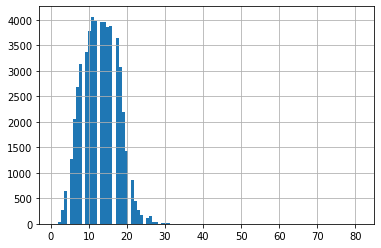

In [130]:
df_train['sentence_cut_len'] = df_train['sentence_cut'].apply(len)
df_train['sentence_cut_len'].hist(bins=100)

In [131]:
print(df_train['sentence_cut_len'].min())
print(df_train['sentence_cut_len'].max())
print(df_train['sentence_cut_len'].std())
print(df_train['sentence_cut_len'].mean())

1
81
4.5526757257246
12.904891304347826


In [132]:
(df_train['sentence_cut_len'] <= 20).sum() / len(df_train)

0.960119940029985

In [133]:
word_count_dict = defaultdict(int)

for sentence in df_train['sentence_cut']:
    for word in sentence:
        word_count_dict[word] += 1

word_count_dict = dict(list(sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)))
word_count_sort = [word for word in word_count_dict]

# Preprocessing

1. truncate
2. delete number

In [134]:
TRUNCATE_LEN = 20


def is_num(word):
    try:
        int(word)
        return True
    except:
        return False

df_train['sentence_clean'] = df_train['sentence_cut'].copy()

df_train['sentence_clean'] = df_train['sentence_clean'].apply(
    lambda sentence: [word for word in sentence if not is_num(word)])

df_train['sentence_clean'] = df_train['sentence_clean'].apply(
    lambda sentence: sentence[:TRUNCATE_LEN])


df_train['sentence_clean'] = [' '.join(x) for x in df_train['sentence_clean']]

# Tfidf Model

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [136]:
MAX_FEATURES = 9000
TOP_N_STOP = 100
TAIL_N_STOP = 3000

tfidf = TfidfVectorizer(
    max_features=9000, 
    stop_words=word_count_sort[:TOP_N_STOP] + word_count_sort[-TAIL_N_STOP:])
X = tfidf.fit_transform(df_train['sentence_clean'])
X.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['02', '100gift', '11', '12v', '13', '15', '17', '18', '19', '2018lpl', '23', '24', '35', '3524', '3q', '3rd', '3v3', '42', '44', '48', '51', '53', '5d4', '60', '63', '6366', '673', '68', '6ov', '80', '87', '88', '8945', '8f', '8l', '92', '96', '97', '99', 'aba', 'afs', 'anna', 'arena', 'arte', 'as', 'b21', 'b2e', 'bb', 'bella', 'boeing747', 'brp', 'call', 'ccrmanager', 'chuck', 'cidex', 'cioe', 'cmos', 'coast', 'comex', 'converse', 'cosplay', 'cybermiles', 'dag', 'daniel', 'day48', 'db11', 'demon', 'demoncrystals', 'din1451', 'disco', 'diss', 'dragon', 'dsp', 'dx7', 'elon', 'est', 'ex260', 'ex360', 'expma', 'f6', 'fed', 'ff7', 'gabe', 'gabrielle', 'gadot', 'gal', 'gamalon', 'gpd', 'gpu', 'gs3', 'gt500', 'gx', 'hello', 'helvetica', 'homepod', 'hpe', 'hpv', 'ia', 'iamd', 'im', 'ix35', 'jump', '

(53360, 9000)

In [137]:
x_train, x_valid, y_train, y_valid = train_test_split(X, df_train['label'], test_size=0.2)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(42688, 9000)
(42688,)
(10672, 9000)
(10672,)


In [138]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pre = rf.predict(x_valid)
accuracy_score(y_pre, y_valid)

0.5002811094452774